In [ ]:
import pandas as pd
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", 50)

import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
from datetime import datetime as dt
import glob
import os

In [307]:
# importing json files

dfs=[]
for file in glob.glob("data/*.json"):
    dataframe = pd.read_json(file)['posts']
    # flatten the structure
    dataframe = pd.json_normalize(dataframe)
    # insert file names
    dataframe['file_name'] = os.path.basename(file)
    dfs.append(dataframe)

# concatenate all data and drop repeated entries
df=pd.concat(dfs).drop_duplicates(subset='uuid', keep='last')

In [308]:
# slicing out only relevant columns 

selected_columns = [
    'file_name',
    'uuid', 
    'title',
    'content',
    'post_flair_text',
    'author',
    'author_flair_text',
    'created',
    'comments',
    'score_up',
    'preview',
    'link',
    'domain',
    'is_image',
    'is_video',
    'video_link'
    ]	
df = df[selected_columns]

# Replace empty cell with Nan
dataframe = dataframe.replace(r'^\s*$', np.nan, regex=True)

# Format datetime
df['created'] = pd.to_datetime(df.created, unit='ms').dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
# crate a column storing "date" 
df['created_date'] = df['created'].dt.date
df['created_date'] = pd.to_datetime(df['created_date'])


# Fix empty or ill-formed domain column
selfpost_mask = df.domain.str.match('^$')
df.loc[selfpost_mask, 'domain'] = 'self_post'

df.created_date.value_counts().sort_index()

/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_31564/2641861775.py:24: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



created_date
2024-07-21     62
2024-07-22    576
2024-07-23    615
2024-07-24    599
2024-07-25    620
2024-07-26    586
2024-07-27    629
2024-07-28    623
2024-07-29    646
2024-07-30    581
2024-07-31    622
2024-08-01    582
2024-08-02    624
2024-08-03    636
2024-08-04    635
2024-08-05    647
2024-08-06    614
2024-08-07    584
2024-08-08    608
2024-08-09    604
2024-08-10    585
2024-08-11    622
2024-08-12    674
2024-08-13    605
2024-08-14    612
2024-08-15    618
2024-08-16    609
2024-08-17    616
2024-08-18    590
2024-08-19    653
2024-08-20    589
2024-08-21    607
2024-08-22    621
2024-08-23    618
2024-08-24    588
2024-08-25    591
2024-08-26    626
2024-08-27    596
2024-08-28    599
2024-08-29    612
2024-08-30    607
2024-08-31    598
2024-09-01    576
2024-09-02    607
2024-09-03    622
2024-09-04     17
Name: count, dtype: int64

In [309]:
df.head()

,file_name,uuid,title,content,post_flair_text,author,author_flair_text,created,comments,score_up,preview,link,domain,is_image,is_video,video_link,created_date
2,20240806-141246_page6.json,17txVxLh4h,🚽 Only 17% of Americans View Radical-Left Tim Walz Positively 💩,,THE BADDIES,MythArcana,,2024-08-06 12:16:27.731000-04:00,9,74,https://media.patriots.win/preview/17txVxLh4h.png,https://media.scored.co/post/Te1QiisbCGPR.png,media.scored.co,True,False,,2024-08-06
3,20240806-141246_page6.json,17txVxL8ye,Gwen Walz is just as crazy left as her husband 🤪,,,AZDesertRat,,2024-08-06 11:10:45.696000-04:00,10,88,https://media.patriots.win/preview/17txVxL8ye.png,https://twitter.com/LauraLoomer/status/1820837157554041212,twitter.com,False,False,,2024-08-06
4,20240806-141246_page6.json,17txVxKasX,"Felony charges against teen who rode scooter, left skid marks on Spokane Pride crosswalk dismissed",,,Sea_Still,,2024-08-06 10:11:14.820000-04:00,10,105,https://media.patriots.win/preview/17txVxKasX.png,https://thepostmillennial.com/felony-charges-against-teen-who-rode-scooter-left-skid-marks-on-spokane-pride-crosswalk-dismissed?utm_campaign=64466,thepostmillennial.com,False,False,,2024-08-06
5,20240806-141246_page6.json,17txVxLhCw,Donald Trump: 17 million primary votes Kamala Harris: 0 primary votes,,,biden_didnt_win,,2024-08-06 12:21:04.849000-04:00,3,69,https://media.patriots.win/preview/17txVxLhCw.png,https://media.patriots.win/post/cS4ZO2P9yD7f.jpeg,media.patriots.win,True,False,,2024-08-06
6,20240806-141246_page6.json,17txVxKs3q,Break the Cycle,,,foxhound,,2024-08-06 10:50:11.440000-04:00,3,92,https://media.patriots.win/preview/17txVxKs3q.png,https://media.scored.co/post/Xej4O0IbECnu.jpeg,media.scored.co,True,False,,2024-08-06


In [310]:
# Unpack shortened domains
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import tldextract

common_shorts = [
    "adf.ly", "adfoc.us", "amzn.to", "atominik.com", "ay.gy", "b.link", "bhpho.to", "bit.ly", "bit.do", 
    "bn.gy", "branch.io", "buff.ly", "ceesty.com", "chollo.to", "cli.re", "cli.fm", "cutt.ly", "cutt.us", 
    "db.tt", "f.ls", "fa.by", "fb.me", "flip.it", "fumacrom.com", "git.io", "geni.us", "goo.gl", "gns.io", 
    "hmm.rs", "ht.ly", "hyperurl.co", "ity.im", "intamema.com", "is.gd", "j.gs", "j.mp", "kutt.it", "ldn.im", 
    "linklyhq.com", "microify.com", "mzl.la", "nmc.sg", "nowlinks.net", "ow.ly", "prf.hn", "plu.sh", "q.gs", 
    "qr.ae", "qr.net", "rebrand.ly", "rb.gy", "rlu.ru", "rotf.lol", "s.coop", "s.id", "sh.st", "soo.gd", 
    "shortcm.xyz", "short.gy", "shortcm.xyz", "shorturl.at", "smu.sg", "smq.tc", "snip.ly", "snipr.com", 
    "snipurl.com", "snurl.com", "split.to", "surl.li", "t.co", "t.ly", "t2m.io", "tiny.cc", "tiny.pl", 
    "tinyium.com", "tinyurl.com", "tiny.one", "tny.im", "tny.sh", "tr.im", "trib.al", "u.to", "v.gd", 
    "virg.in", "vzturl.com", "waa.ai", "washex.am", "x.co", "y2u.be", "yourwish.es", "zpr.io", "1url.com", 
    "2.gp", "3.ly", "4sq.com", "6url.com", "7.ly", "9.bb", "amp.gs", "atz.bz", "binged.it",
    "budurl.com", "cort.as", "decenturl.com", "dft.ba", "goo.gl", "inbound.org", "itsh.bo", "mcaf.ee",
    "n.pr", "nyti.ms", "on.fb.me", "prsm.tc", "redd.it", "tnw.to", "twt.fi", "u.nu", "virl.io", "wapo.st",
    "wp.me", "xrl.us",  "zurl.ws", "dlvr.it", 'msft.it', "lnkd.in ", 'spr.ly', 'rebelne.ws', 'scroll.in', 'ab.co',
    'hubs.li', 'bbc.in', 'nature.ly', 'cbsn.ws' , 'brnw.ch', 'youtu.be'
                ]

# Set up a Requests session with retries
session = requests.Session()
headers = {
    'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
    'Accept-Encoding': 'gzip, deflate, br',
    'Accept-Language': 'en-US,en;q=0.5',
    'Connection': 'keep-alive',
    'Upgrade-Insecure-Requests': '1',
    'DNT': '1',
    'referer': 'https://www.google.com/'
}

headers = {
        'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36',
        'referer':'https://google.com',
        'DNT':'1'
    }

# session.headers.update(headers)
retries = Retry(total=4, backoff_factor=1, status_forcelist=[502, 503, 504])
session.mount('http://', HTTPAdapter(max_retries=retries))
session.mount('https://', HTTPAdapter(max_retries=retries))

def check_connection(host='http://www.google.com'):
    try:
        session.get(host, timeout=1)
        return True
    except (requests.ConnectionError, requests.Timeout):
        return False

def wait_for_connection(interval=30, max_attempts=10):
    attempts = 0
    while not check_connection() and attempts < max_attempts:
        time.sleep(interval)
        attempts += 1
    return attempts < max_attempts

def resolve_url_head(short_url):
    if not wait_for_connection():
        raise ConnectionError("Internet connection could not be re-established.")
    try:
        response = requests.head(short_url, allow_redirects=True, timeout=1)
        return response.url if response.status_code == 200 else short_url
    except requests.RequestException:
        return short_url
    
def resolve_url_get(short_url):
    if not wait_for_connection():
        raise ConnectionError("Internet connection could not be re-established.")
    try:
        response = session.get(short_url, allow_redirects=True, timeout=5)
        return response.url if response.status_code == 200 else short_url
    except requests.RequestException:
        return short_url
    if not wait_for_connection():
        raise ConnectionError("Internet connection could not be re-established.")
    try:
        response = session.get(url=shortend_url, allow_redirects=True, timeout=1)        
   
    except requests.RequestException:
        return None    
    
df['domain'] = df['domain'].apply(lambda x: tldextract.extract(x).domain + "." + tldextract.extract(x).suffix if x != 'self_post' else 'self_post')
short_mask = df['domain'].isin(common_shorts)
df.loc[short_mask, 'domain'] = df.loc[short_mask, 'link'].apply(lambda x: resolve_url_get(x)).apply(lambda x: tldextract.extract(x).domain + "." + tldextract.extract(x).suffix)

In [315]:
# The top 10 most-shared domains on The Ronald's landing page
df.domain.value_counts(normalize=True).head(10)

domain
twitter.com             0.378253
scored.co               0.269156
patriots.win            0.164736
self_post               0.029159
thegatewaypundit.com    0.018577
youtube.com             0.014035
videy.co                0.010356
breitbart.com           0.008630
rumble.com              0.006631
zerohedge.com           0.006540
Name: proportion, dtype: float64

In [316]:
# Drop posts from 2024-07-21
df = df[df['created_date'] != '2024-07-21']

# Keep only the top 500 posts by "score_up" from each date so that the playing field is more leveled
df = df.groupby('created_date').apply(lambda x: x.nlargest(500, 'score_up')).reset_index(drop=True)

/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_31564/1070751727.py:5: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [317]:
# Extract twitter handles 
df[df.domain =='twitter.com'].link.str.split('/').str[3].str.lower()
df.loc[df.domain == 'twitter.com', 'twitter_handle'] = df[df.domain == 'twitter.com'].link.str.split('/').str[3].str.lower()
df['twitter_handle'].fillna(np.nan, inplace=True)

# Top twitter handles mentioned
df.value_counts('twitter_handle', ascending=False).head(10)

/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_31564/3006735851.py:4: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





twitter_handle
elonmusk        308
behizytweets    296
endwokeness     190
libsoftiktok    158
catturd2        117
bennyjohnson    112
dc_draino       111
immeme0         110
trumpwarroom    103
nicksortor      100
Name: count, dtype: int64

In [324]:
# A function that returns the top posts in interactive format

    
def top_posts_lastNdays(num, Ndays, save_table=False):
    end_date = datetime.datetime.now()
    start_date = end_date - datetime.timedelta(days=Ndays)
    top_posts = df[df.created_date >= start_date].nlargest(num,'score_up')
    top_posts['post_link'] = "https://patriots.win/p/" + top_posts['uuid']
    top_posts['title'] = top_posts.apply(lambda row: f'<a href="{row["post_link"]}">{row["title"]}</a>', axis=1)
    top_posts = top_posts[['title', 
                           'score_up', 
                           'comments', 
                           'author'
                           ]]
    
    
    top_posts = top_posts.reset_index().drop(columns='index')
    top_posts.index = np.arange(1, len(top_posts)+1)

    if save_table:
        html_content = top_posts.to_html(render_links=True, 
                                         justify='center', 
                                         escape=False,
                                         classes='table table-striped table-hover', 
                                         table_id='my_table')
        
        with open(f'viz/{num}_most_popular_posts_in_the_last_{Ndays}_day(s).html', "w") as html_file:
            html_file.write(f"""
                <html>
                <head>
                <link rel="stylesheet" type="text/css" href="https://cdn.datatables.net/1.10.21/css/jquery.dataTables.css">
                <script type="text/javascript" charset="utf8" src="https://code.jquery.com/jquery-3.5.1.js"></script>
                <script type="text/javascript" charset="utf8" src="https://cdn.datatables.net/1.10.21/js/jquery.dataTables.js"></script>
                <script>
                $(document).ready( function () {{
                    $('#my_table').DataTable();
                }} );
                </script>
                </head>
                <body>
                {html_content}
                </body>
                </html>
            """)
                                         
    return top_posts


top_posts_lastNdays(num=10, Ndays=1, save_table=True)

,title,score_up,comments,author
1,"<a href=""https://patriots.win/p/1994fewnUV"">Know the differences.</a>",72,1,Alecbaldwinsgun
2,"<a href=""https://patriots.win/p/1994fex48h"">This guy!</a>",67,0,John-Miller
3,"<a href=""https://patriots.win/p/1994fex4Cr"">Scott Presler is maybe a week or two from flipping Luzerne County, PA! Dem advantage down to 340 voters!</a>",67,5,DonttrustChina
4,"<a href=""https://patriots.win/p/1994fewnYe"">Christian teacher continues to be thrown in jail </a>",60,3,deletedandreacted
5,"<a href=""https://patriots.win/p/1994fex44a"">This guy on Tik Tok does random drops into cities on Google Maps to see if they’re shitty or not, and the Baltimore one is one of the funniest things you'll ever see</a>",57,5,I-am-Orlando
6,"<a href=""https://patriots.win/p/1994fex44b"">Christ Jesus is Our Lord. Our Savior is He.</a>",57,3,Ghost_of_ADLStan
7,"<a href=""https://patriots.win/p/1994fewnUX"">HEADLINE #1: ""Harris running mate Tim Walz marched with ‘Abolish ICE’ protesters in 2018"" HEADLINE #2: ""ICE Arrests Illegal Immigrant Convicted of Sexual Assault Against Virginia Child (Age 13) and 7 Counts of Child Porn""</a>",52,0,Lunar
8,"<a href=""https://patriots.win/p/1994fex4H1"">I miss Norm</a>",47,6,based_trekkie
9,"<a href=""https://patriots.win/p/1994fewnUS"">A man of focus, commitment, and sheer will. I once saw him write three America First policies in a bar... with a pencil. A fucking pencil!</a>",39,0,saltyviewer123
10,"<a href=""https://patriots.win/p/1994fex48g"">Biden's big boy desk is meme gold </a>",39,1,I-am-Orlando


In [325]:
def top_authors_lastNdays(num, Ndays):
    end_date = datetime.datetime.now()
    start_date = end_date - datetime.timedelta(days=Ndays)

    return df[df.created_date >=  start_date].author.value_counts().head(num)

top_authors_lastNdays(num=10, Ndays=1)

author
I-am-Orlando         2
Alecbaldwinsgun      1
John-Miller          1
DonttrustChina       1
deletedandreacted    1
Ghost_of_ADLStan     1
Lunar                1
based_trekkie        1
saltyviewer123       1
FreeFire             1
Name: count, dtype: int64

In [232]:
import spacy
import nltk
nltk.download('wordnet')
from nltk import bigrams, trigrams
nlp = spacy.load('en_core_web_lg')
stopwords = list(nlp.Defaults.stop_words) 
stopwords.extend(["ago", 'old'])

import contractions
import emoji
import re



def clean_it_all_up (text, extra_stops):
    text = emoji.replace_emoji(text)
    text = contractions.fix(text)
    text = re.sub(r'\W+', ' ', text)
    doc = nlp(text)
    lemmatized_tokens = []
    
    for token in doc:
        if (
            token.text.lower() not in stopwords 
            and (extra_stops is None or token.text.lower() not in extra_stops) 
            # and token.pos_ in {'NOUN', 'PROPN', 'VERB', 'ADJ'} 
            # and token.ent_type_ not in {'GPE', 'LOC'}
            and token.pos_ not in {"AUX",
                                   "ADP",
                                   "CONJ", 
                                   "CCONJ", 
                                   "DET", 
                                   "INTJ", 
                                   "PART", 
                                   "PUNCT",
                                   "SCONJ", 
                                   "SYM", 
                                   "X", 
                                   "SPACE"}
        ):
          
            
            lemmatized_tokens.append(token.lemma_.lower())
            
    return " ".join(lemmatized_tokens)   


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/keenansmacbookairm3/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [233]:
def date_selection(start_date, end_date):
    start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    end_date = end_date = datetime.datetime.strptime(end_date, "%Y-%m-%d")

    date_list = []
    current_date = start_date
    date_list.append(current_date.strftime('%Y-%m-%d'))

    while current_date < end_date:
        next_date = current_date + datetime.timedelta(days=1)
        next_date = next_date
        if next_date >= end_date:
            next_date = end_date
        date_list.append(next_date.strftime('%Y-%m-%d'))
        current_date = next_date

    return date_list


In [234]:
def ngram_generator(dataframe, num, start_date, end_date, extra_stops, top_n=None):
    
    date_list = date_selection(start_date, end_date)

    cleaned_tokens = ' '.join(dataframe[dataframe.created_date.isin(date_list)]['title'].apply(lambda x: clean_it_all_up(x, extra_stops)).tolist())

    if num == 1:
        ngram = pd.Series(cleaned_tokens.split()).value_counts()
    elif num == 2:
        ngram = pd.Series(list(bigrams(cleaned_tokens.split()))).value_counts()
    elif num == 3:
        ngram = pd.Series(list(trigrams(cleaned_tokens.split()))).value_counts()
    else:
        raise ValueError('Invalid number. Must choose between 1, 2, or 3.')
    
    ngram = ngram[ngram > 1].head(top_n)
    return ngram


In [235]:
# Function of returning top ngrams from the past 24 hours

def ngram_generator_24hrs(dataframe, num, extra_stops, top_n=None):
    end_date = datetime.datetime.now()
    start_date = end_date - datetime.timedelta(days=1)
    
    start_date = start_date.strftime("%Y-%m-%d")
    end_date = end_date.strftime("%Y-%m-%d")
    
    return ngram_generator(dataframe, num, start_date, end_date, extra_stops, top_n)

In [236]:
# A function of returning top ngrams from the past 7 days

def ngram_generator_7days(dataframe, num, extra_stops, top_n=None):
    end_date = datetime.datetime.now()
    start_date = end_date - datetime.timedelta(days=7)
    
    start_date = start_date.strftime("%Y-%m-%d")
    end_date = end_date.strftime("%Y-%m-%d")
    
    return ngram_generator(dataframe, num, start_date, end_date, extra_stops, top_n)

In [237]:
# A function to return a wordcloud chart covering a specific period of dates
from wordcloud import WordCloud

def ngram_cloud(dataframe, num, start_date, end_date, extra_stops, top_n=None):
    ngram = ngram_generator(dataframe, num, start_date, end_date, extra_stops, top_n)
    words_cloud = pd.DataFrame(ngram, columns=['count']).reset_index().rename(columns={'index': 'phrases'})
    words_cloud['phrases'] = words_cloud['phrases'].apply(lambda x: ', '.join(x) if isinstance(x,tuple) else x)
    words_cloud['phrases'] = words_cloud['phrases'].str.replace(',', '')
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='flag_r').\
    generate_from_frequencies(words_cloud.set_index('phrases')['count'].to_dict())
    plt.figure(figsize=(10,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

In [269]:
# A function to return a wordcloud chart covering ONLY the past 24 hours

def ngram_24hrs_cloud(dataframe, num, save_viz, extra_stops, set_title=False, top_n=None):
    ngram = ngram_generator_24hrs(dataframe, num, extra_stops, top_n)
    words_cloud = pd.DataFrame(ngram, columns=['count']).reset_index().rename(columns={'index': 'phrases'})
    words_cloud['phrases'] = words_cloud['phrases'].apply(lambda x: ', '.join(x) if isinstance(x,tuple) else x)
    words_cloud['phrases'] = words_cloud['phrases'].str.replace(',', '')
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='flag_r').\
    generate_from_frequencies(words_cloud.set_index('phrases')['count'].to_dict())
    plt.figure(figsize=(10,8))
    plt.imshow(wordcloud, 
               interpolation='nearest',
               aspect="auto"
               )
    
    if set_title:
        plt.title(f"Most-mentioned {top_n} bigrams in the last 24 hours",
                fontsize=20,
                pad=25,
                )
    plt.axis('off')

    if save_viz is not None:
        plt.savefig(f"viz/{save_viz}.jpeg",
                    dpi=600
                    )
        plt.show()
    else:
        plt.show()

/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_31564/2951235605.py:5: FutureWarning:

The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.



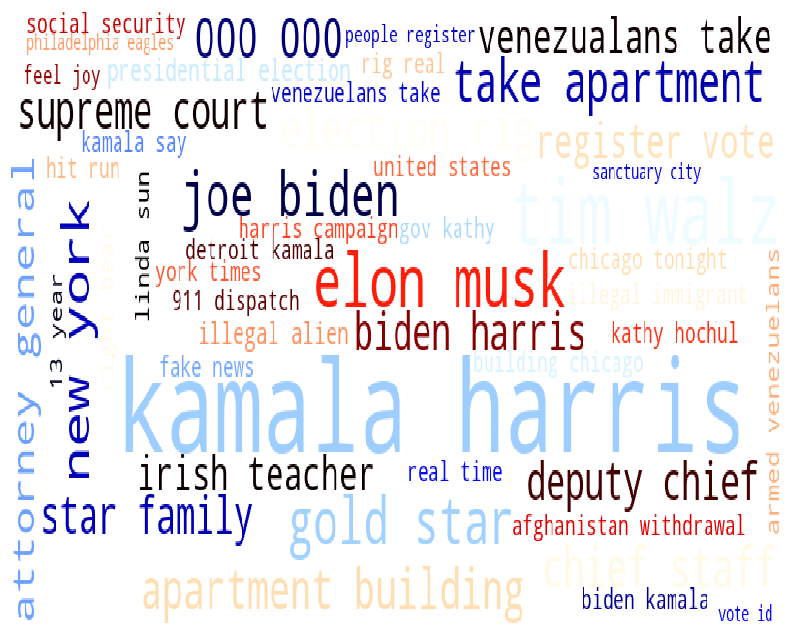

In [270]:
# creating and saving the top 50 bigrams from the last 24 hours
dataframe = df
num = 2
top_n = 50
save_viz = 'bigrams_wordcloud_24hrs'
extra_stops=['trump']
ngram_24hrs_cloud(dataframe = dataframe, num=num, top_n=top_n, save_viz=save_viz, extra_stops=extra_stops)



In [240]:
# A function to return a wordcloud chart covering ONLY the past 7 days

def ngram_7days_cloud(dataframe, num, save_viz, extra_stops, top_n=None):
    ngram = ngram_generator_7days(dataframe, num, extra_stops, top_n=None)
    words_cloud = pd.DataFrame(ngram, columns=['count']).reset_index().rename(columns={'index': 'phrases'})
    words_cloud['phrases'] = words_cloud['phrases'].apply(lambda x: ', '.join(x) if isinstance(x,tuple) else x)
    words_cloud['phrases'] = words_cloud['phrases'].str.replace(',', '')
    wordcloud = WordCloud(width=800, height=400, background_color='white').\
    generate_from_frequencies(words_cloud.set_index('phrases')['count'].to_dict())
    plt.figure(figsize=(10,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Top {top_n} bigrams in the last 7 days",
              fontsize=20,
              pad=25,
              )

    if save_viz is not None:
        plt.savefig(f"viz/{save_viz}.jpeg",
                    dpi=600
                    )
        plt.show()
    else:
        plt.show()

In [241]:
# A summary table of authors based on a given date
def top_acounts(dataframe, start_date, end_date, top_n=None):
    date_list = date_selection(start_date, end_date)
    top_authors = dataframe[dataframe['created_date'].isin(date_list)]['author'].value_counts().reset_index()
    top_authors = top_authors[top_authors['count']>1]
    comments_total = dataframe.groupby('author').comments.sum()
    upvotes_total = dataframe.groupby('author').score_up.sum()
    top_authors =  top_authors.merge(comments_total, on='author').merge(upvotes_total, on='author')
    top_authors = top_authors.rename(columns={
                                        'author': 'top_authors',
                                        'count' : 'posts',
                                        'comments': 'accumulated_comments',
                                        'score_up': 'accumulated_upvotes'
                                        })
    top_authors = top_authors.sort_values('posts', ascending=False).head(top_n)
    return  top_authors

In [242]:
# This function returns the most posted domains from a specific period of time

def top_domains(dataframe, start_date, end_date, top_n=None):
    date_list = date_selection(start_date, end_date)
    top_urls = dataframe[dataframe['created_date'].isin(date_list)]['domain'].value_counts(dropna=False, normalize=True).head(top_n)
    return top_urls

In [243]:
# This function returns the most posted domains from the last 7 days

def top_domains_7days(dataframe, top_n=None):
    end_date = datetime.datetime.now()
    start_date = end_date - datetime.timedelta(days=7)
    
    start_date = start_date.strftime("%Y-%m-%d")
    end_date = end_date.strftime("%Y-%m-%d")

    date_list = date_selection(start_date, end_date)
    top_urls = dataframe[dataframe['created_date'].isin(date_list)]['domain'].value_counts(dropna=False, normalize=True).head(top_n)
    return top_urls

In [244]:
# Popular Twitter accounts on The Ronald

def top_xitter(dataframe, start_date, end_date, top_n=None):
    date_list = date_selection(start_date, end_date)
    xiter_accounts = dataframe[(dataframe.link.str.contains('twitter.com'))& (dataframe['created_date'].isin(date_list))]
    top_xitter = xiter_accounts['link'].str.split('/').str[3].str.lower().value_counts(normalize=False, dropna=False).head(top_n)
    return top_xitter

In [245]:
# A date-based n-gram generator
# useful for making time-series charts 

def new_ngram_generator(dataframe, num, start_date, end_date, extra_stops, top_n=None):
    # Filter dates
    date_list = date_selection(start_date, end_date)
    
    # Filter and process data
    filtered_df = dataframe[dataframe.created_date.isin(date_list)]
    filtered_df['cleaned_title'] = filtered_df['title'].apply(lambda x: clean_it_all_up(x, extra_stops))

    
    ngrams_with_dates = []
    
    for index, row in filtered_df.iterrows():
        tokens = row['cleaned_title'].split()
        if num ==1:
            unigrams_list = list(tokens)
            for unigram in unigrams_list:
                ngrams_with_dates.append((unigram, row['created_date']))
        elif num == 2:
            bigrams_list = list(bigrams(tokens))
            for bigram in bigrams_list:
                ngrams_with_dates.append((bigram, row['created_date']))
        elif num == 3:
            trigrams_list = list(trigrams(tokens))
            for trigram in trigrams_list:
                ngrams_with_dates.append((trigram, row['created_date']))
        else:
            raise ValueError('Invalid number. Must choose between 2 or 3.')
    
    ngram_df = pd.DataFrame(ngrams_with_dates, columns=['ngram', 'date']).head(top_n)
    return ngram_df


In [246]:
def ngram_time_series(dataframe, num, start_date, end_date, save_viz, extra_stops, top_n=None):

    ngrams_df = new_ngram_generator(dataframe, num, start_date, end_date, extra_stops)

    ngrams_df['date'] = pd.to_datetime(ngrams_df['date'])

    ngrams_counts = ngrams_df.groupby([ngrams_df['date'].dt.to_period('d'), 'ngram']).size().reset_index(name='count')

    top_ngrams = ngrams_counts.groupby('ngram')['count'].sum().nlargest(top_n).index

    top_ngrams_counts = ngrams_counts[ngrams_counts['ngram'].isin(top_ngrams)]

    top_ngram_pivot = top_ngrams_counts.pivot(index='date', columns='ngram', values='count').fillna(0)

    top_ngram_pivot.index = top_ngram_pivot.index.to_timestamp()

    plt.figure(figsize=(10, 8))


    top_ngram_plot = sns.lineplot(data=top_ngram_pivot)

    plt.xlabel('')
    plt.ylabel('Mention count')
    plt.title(f'Top bigrams on the landing page of The Ronald between {start_date} and {end_date}')

    plt.xticks(rotation=45) 
    plt.grid(True)

    plt.legend(title='Top Bigrams', bbox_to_anchor=(1.3, 1), loc='upper right')
    
    if save_viz is not None:
        plt.savefig(f"viz/{save_viz}.jpeg",
                    dpi=600
                    )
        plt.show()
    else:
        plt.show()

In [247]:
# create interactive charts with Plotly

import plotly.graph_objs as go

def ngram_time_series_interactive(dataframe, num, start_date, end_date, save_viz, extra_stops, top_n=None):
    ngrams_df = new_ngram_generator(dataframe, num, start_date, end_date, extra_stops)

    ngrams_df['date'] = pd.to_datetime(ngrams_df['date'])

    ngrams_counts = ngrams_df.groupby([ngrams_df['date'].dt.to_period('d'), 'ngram']).size().reset_index(name='count')

    top_ngrams = ngrams_counts.groupby('ngram')['count'].sum().nlargest(top_n).index

    top_ngrams_counts = ngrams_counts[ngrams_counts['ngram'].isin(top_ngrams)]

    top_ngram_pivot = top_ngrams_counts.pivot(index='date', columns='ngram', values='count').fillna(0)

    top_ngram_pivot.index = top_ngram_pivot.index.to_timestamp()

    fig = go.Figure()

    for ngram in top_ngram_pivot.columns:
        fig.add_trace(go.Scatter(
            x=top_ngram_pivot.index, 
            y=top_ngram_pivot[ngram], 
            mode='lines', 
            name=str(ngram)))

    fig.update_layout(
        width=1400,
        height=800,
        title=f'Top bigrams on the landing page of The Ronald between {start_date} and {end_date}',
        xaxis_title='Date',
        yaxis_title='Mention count',
        xaxis=dict(tickangle=45),
        legend_title_text='Top Bigrams'
    )

    if save_viz is not None:
        fig.savefig(f"viz/{save_viz}.jpeg",
                    dpi=600
                    )
        fig.show()
    else:
        fig.show()

In [248]:
# This function would only cover the past n days

def ngram_time_last_n_days_interactive(dataframe, num, last_ndays, extra_stops, top_n=None):
    end_date = pd.to_datetime(dataframe['created_date'].max())
    start_date = end_date - pd.Timedelta(days=last_ndays)
    start_date= start_date.strftime("%Y-%m-%d")
    end_date= end_date.strftime("%Y-%m-%d")

    ngrams_df = new_ngram_generator(dataframe, num, start_date, end_date, extra_stops)

    ngrams_df['date'] = pd.to_datetime(ngrams_df['date'])
    ngrams_counts = ngrams_df.groupby([ngrams_df['date'].dt.to_period('d'), 'ngram']).size().reset_index(name='count')
    
    top_ngrams = ngrams_counts.groupby('ngram')['count'].sum().nlargest(top_n).index
    top_ngrams_counts = ngrams_counts[ngrams_counts['ngram'].isin(top_ngrams)]

    top_ngram_pivot = top_ngrams_counts.pivot(index='date', columns='ngram', values='count').fillna(0)
    top_ngram_pivot.index = top_ngram_pivot.index.to_timestamp()


    y_max=top_ngram_pivot.values.max()
    y_range=[0, y_max * 1.1]

    fig = go.Figure()

    for ngram in top_ngram_pivot.columns:
        fig.add_trace(go.Scatter(
            x=top_ngram_pivot.index, 
            y=top_ngram_pivot[ngram], 
            mode='lines', 
            name=str(ngram)))
        
    fig.update_traces(line={'width': 5})

    fig.update_layout(
        width=1200,
        height=800,
        title=f'Top bigrams on the landing page of The Ronald between {start_date} and {end_date}',
        xaxis=dict(title='Date',
                   tickangle=45), 
        yaxis=dict(title='Mention count', 
                   range=y_range),
        legend_title_text='Top Bigrams'
)

    fig.show()

In [277]:

# This function would only cover the past 7 days

def ngram_time_last_7_days_interactive(dataframe, num, save_viz,extra_stops, set_title=False, top_n=None):
    end_date = pd.to_datetime(df['created_date'].max())
    start_date = end_date - pd.Timedelta(days=7)
    start_date= start_date.strftime("%Y-%m-%d")
    end_date= end_date.strftime("%Y-%m-%d")

    ngrams_df = new_ngram_generator(dataframe, num, start_date, end_date, extra_stops)

    ngrams_df['date'] = pd.to_datetime(ngrams_df['date'])
    ngrams_counts = ngrams_df.groupby([ngrams_df['date'].dt.to_period('d'), 'ngram']).size().reset_index(name='count')
    
    top_ngrams = ngrams_counts.groupby('ngram')['count'].sum().nlargest(top_n).index
    top_ngrams_counts = ngrams_counts[ngrams_counts['ngram'].isin(top_ngrams)]

    top_ngram_pivot = top_ngrams_counts.pivot(index='date', columns='ngram', values='count').fillna(0)
    top_ngram_pivot.index = top_ngram_pivot.index.to_timestamp()


    y_max=top_ngram_pivot.values.max()
    y_range=[0, y_max * 1.1]

    fig = go.Figure()

    for ngram in top_ngram_pivot.columns:
        fig.add_trace(go.Scatter(
            x=top_ngram_pivot.index, 
            y=top_ngram_pivot[ngram], 
            mode='lines', 
            name=str(ngram)))
        
    fig.update_traces(line={'width': 5})


    layout= dict(
        width=1200,
        height=800,
        xaxis=dict(title='Date',
                   tickangle=45), 
        yaxis=dict(title='Mention count', 
                   range=y_range),
        legend_title = dict(
            text= '<b>Top Bigrams<br>(try cliking these variables)</b>',
            font = dict(family = "Courier", 
                        color= 'firebrick',
                        size = 15),
        )   
)
    if set_title:
        layout['title'] = dict(
            text = f"Top {top_n} bigrams on The Ronald's landing page in the last 7 days",
            font = dict(family = "Ariel", 
                        size = 30),
            pad=dict(t=20)
        )
    

    if save_viz is not None:
        fig.write_html(f"viz/{save_viz}.html")
        fig.show()
    else:
        fig.show()


In [278]:
dataframe=df
num=2
top_n=20
save_viz = "interactive_bigrams_7days"
extra_stops=['trump']
ngram_time_last_7_days_interactive(dataframe=dataframe, 
                                   num=num, 
                                   save_viz=save_viz, 
                                   extra_stops=extra_stops, 
                                   top_n=top_n)

/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_31564/1221168534.py:9: FutureWarning:

The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.

/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_31564/1221168534.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

